<center>

![Workflow Diagram](workflow_v3.pdf.jpg)

</center>

# Quantum Learning Procedure

In [15]:
import sys
from pathlib import Path
qml_path = (Path.cwd() / "../../QML").resolve()
sys.path.insert(0, str(qml_path))

from Qsun.Qkernels import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from Qsun.Qcircuit import *
from Qsun.Qwave import *
from Qsun.Qencodes import *
from Qsun.Qdata import *

import numpy as np
import matplotlib.pyplot as plt
from src.load_datasets import *
from src.kernel_evaluation import *
from tqdm import tqdm
from typing import Dict, Tuple, Callable, List
from itertools import combinations
import problexity as px

np.random.seed(1234)

### Loading 9 ansatzes from Qencodes.py

In [16]:
ENCODING_REGISTER = {
    "YZ_CX": {
        "fn": YZ_CX_encode,
        "has_params": True,
        "has_layers": True,
    },
    "HighDim": {
        "fn": HighDim_encode,
        "has_params": False,
        "has_layers": False,
    },
    "HZY_CZ": {
        "fn": HZY_CZ_encode,
        "has_params": True,
        "has_layers": True,
    },
    "Chebyshev": {
        "fn": Chebyshev_encode,
        "has_params": True,
        "has_layers": True,
    },
    "ParamZFeatureMap": {
        "fn": ParamZFeatureMap_encode,
        "has_params": True,
        "has_layers": True,
    },
    "SeparableRX": {
        "fn": SeparableRXEncoding_encode,
        "has_params": False,
        "has_layers": False,
    },
    "HardwareEfficientRx": {
        "fn": HardwareEfficientEmbeddingRx_encode,
        "has_params": False,
        "has_layers": True,
    },
    "ZFeatureMap": {
        "fn": ZFeatureMap_encode,
        "has_params": False,
        "has_layers": True,
    },
    "ZZFeatureMap": {
        "fn": ZZFeatureMap_encode,
        "has_params": False,
        "has_layers": True,
    },
}

def encode_sample(sample: np.ndarray, encoding_name: str, n_layers: int = 2, 
                  params: np.ndarray = None):
    if encoding_name not in ENCODING_REGISTER:
        raise ValueError(f"Unknown encoding: {encoding_name}")
    config = ENCODING_REGISTER[encoding_name]
    fn = config["fn"]
    if encoding_name == "YZ_CX":
        return fn(sample, params=params, n_layers=n_layers)
    elif encoding_name == "HZY_CZ":
        return fn(sample, params=params, n_layers=n_layers)
    elif encoding_name == "Chebyshev":
        return fn(sample, params=params, n_layers=n_layers)
    elif encoding_name == "ParamZFeatureMap":
        return fn(sample, params=params, n_layers=n_layers)
    elif encoding_name == "HardwareEfficientRx":
        return fn(sample, n_layers=n_layers)
    elif encoding_name == "ZFeatureMap":
        return fn(sample, n_layers=n_layers)
    elif encoding_name == "ZZFeatureMap":
        return fn(sample, n_layers=n_layers)
    elif encoding_name == "HighDim":
        return fn(sample)
    elif encoding_name == "SeparableRX":
        return fn(sample)
    else:
        raise ValueError(f"Unknown encoding: {encoding_name}")

### Quantum Embedding Kernels

In [17]:
def kernel_matrix(X_train: np.ndarray, X_test: np.ndarray,
                                    encoding_name: str, n_layers: int = 2,
                                    params: np.ndarray = None, random_state: int = 42,
                                    verbose: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    encoded_train = []
    for i in range(n_train):
        state = encode_sample(X_train[i], encoding_name, n_layers, params)
        encoded_train.append(state)
    encoded_test = []
    for i in range(n_test):
        state = encode_sample(X_test[i], encoding_name, n_layers, params)
        encoded_test.append(state)
    K_train = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(i, n_train):
            k_ij = state_product(encoded_train[i], encoded_train[j])**2
            K_train[i, j] = k_ij
            K_train[j, i] = k_ij
    K_test = np.zeros((n_test, n_train))
    for i in range(n_test):
        for j in range(n_train):
            K_test[i, j] = state_product(encoded_test[i], encoded_train[j])**2
    
    return K_train, K_test

def total_kernels(X_train: np.ndarray, X_test: np.ndarray,
                      encoding_names: List[str] = None, n_layers: int = 2,
                      random_state: int = 42, verbose: bool = True
                      ) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
    if encoding_names is None:
        encoding_names = list(ENCODING_REGISTER.keys())
    results = {}
    for name in encoding_names:
        try:
            K_train, K_test = kernel_matrix(
                X_train, X_test, name, n_layers, 
                random_state=random_state, verbose=verbose
            )
            results[name] = (K_train, K_test)
        except Exception as e:
            if verbose:
                print(f"  Error: {e}")
            continue
    
    return results

def get_available_encodings() -> List[str]:
    return list(ENCODING_REGISTER.keys())

In [ ]:
datasets = load_datasets(data_dir="datasets",max_qubits=4 ,verbose=True)
X_train, X_test, y_train, y_test = datasets["Iris"]

print(f"\nIris dataset: Train {X_train.shape}, Test {X_test.shape}")
print(f"Available encodings: {get_available_encodings()}")

print("Sample encoding: ZFeatureMap")

K_train, K_test = kernel_matrix(
        X_train, X_test, "ZFeatureMap", n_layers=2, verbose=True
    )


  Skipped: File not found: C:\Users\Dao Duy Tung\Documents\Python\newbie\QuantumLab\ML for beginner\Kernel Discovery\src\pima-indians-diabete.csv
  Skipped: File not found: C:\Users\Dao Duy Tung\Documents\Python\newbie\QuantumLab\ML for beginner\Kernel Discovery\src\BankNote_Authentication.csv
  Skipped: File not found: C:\Users\Dao Duy Tung\Documents\Python\newbie\QuantumLab\ML for beginner\Kernel Discovery\src\haberman.csv

Iris dataset: Train (80, 4), Test (20, 4)
Available encodings: ['YZ_CX', 'HighDim', 'HZY_CZ', 'Chebyshev', 'ParamZFeatureMap', 'SeparableRX', 'HardwareEfficientRx', 'ZFeatureMap', 'ZZFeatureMap']
Sample encoding: ZFeatureMap


In [19]:
datasets = load_datasets(data_dir="datasets",max_qubits=4, verbose=True)
for name, (X_tr, X_te, y_tr, y_te) in datasets.items():
    print(f"\n{name} dataset: Train {X_tr.shape}, Test {X_te.shape}")



Blobs_F2C2 dataset: Train (800, 2), Test (200, 2)

Blobs_F2C3 dataset: Train (800, 2), Test (200, 2)

Blobs_F2C4 dataset: Train (800, 2), Test (200, 2)

Blobs_F4C2 dataset: Train (800, 4), Test (200, 4)

Blobs_F4C3 dataset: Train (800, 4), Test (200, 4)

Blobs_F4C4 dataset: Train (800, 4), Test (200, 4)

Circle dataset: Train (80, 2), Test (20, 2)

Moons dataset: Train (80, 2), Test (20, 2)

Iris dataset: Train (80, 4), Test (20, 4)

Pima dataset: Train (613, 4), Test (154, 4)

Banknote dataset: Train (1097, 4), Test (275, 4)

Haberman dataset: Train (244, 3), Test (61, 3)


### Model Execution

In [ ]:
def total_runs(dataset_name: str = "Iris", 
                                encodings: list = None,
                                n_layers: int = 2,
                                n_runs: int = 10,
                                test_size: float = 0.2,
                                random_state: int = 42,
                                verbose: bool = True):
    if encodings is None:
        encodings = get_available_encodings()
    if verbose:
        print(f"Dataset: {dataset_name}")    
    results_accumulator = {enc: {m: {"train": [], "test": []} 
                                  for m in ["SVM"]} 
                           for enc in encodings}
    for run in tqdm(range(n_runs)):
        seed = random_state + run
        datasets = load_datasets(data_dir="datasets",random_state=seed, test_size=test_size, max_qubits=4, verbose=False)
        X_train, X_test, y_train, y_test = datasets[dataset_name]
        kernels = total_kernels(X_train, X_test, encodings, n_layers, seed, verbose=False)
        for enc_name, (K_train, K_test) in kernels.items():
            for model_name in ["SVM"]:
                result = evaluate_kernel(
                    K_train, K_test, y_train, y_test, enc_name, model_name
                )
                results_accumulator[enc_name][model_name]["train"].append(result.train_accuracy)
                results_accumulator[enc_name][model_name]["test"].append(result.test_accuracy)
    all_results = {}
    for enc_name in encodings:
        enc_results = []
        for model_name in ["SVM"]:
            train_scores = results_accumulator[enc_name][model_name]["train"]
            test_scores = results_accumulator[enc_name][model_name]["test"]
            enc_results.append(KernelEvaluation(
                model_name=model_name,
                encoding_name=enc_name,
                train_accuracy=np.mean(train_scores),
                test_accuracy=np.mean(test_scores),
                train_std=np.std(train_scores),
                test_std=np.std(test_scores)
            ))
        all_results[enc_name] = enc_results
    
    return {"results": all_results}

In [21]:
def summary(all_results):
    print(f"{'Encoding':<22} {'Model':<6} {'Train':<18} {'Test':<18}")
    print("-" * 75)
    
    best_test_acc = 0
    best_config = None
    
    for encoding_name, results in all_results.items():
        for r in results:
            train_str = f"{r.train_accuracy:.4f} ± {r.train_std:.4f}"
            test_str = f"{r.test_accuracy:.4f} ± {r.test_std:.4f}"
            print(f"{r.encoding_name:<22} {r.model_name:<6} {train_str:<18} {test_str:<18}")
            if r.test_accuracy > best_test_acc:
                best_test_acc = r.test_accuracy
                best_config = r
    
    print("-" * 75)
    print(f"Best: {best_config.encoding_name} + {best_config.model_name} = {best_test_acc:.4f} ± {best_config.test_std:.4f}")

In [22]:
result_Iris = total_runs(
    dataset_name="Iris",
    encodings=None,
    n_layers=2,
    n_runs=10,
    test_size=0.2,
    random_state=42,
    verbose=True
)
summary(result_Iris["results"])

Dataset: Iris


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

Encoding               Model  Train              Test              
---------------------------------------------------------------------------
YZ_CX                  SVM    0.9387 ± 0.0118    0.5500 ± 0.1789   
HighDim                SVM    1.0000 ± 0.0000    1.0000 ± 0.0000   
HZY_CZ                 SVM    1.0000 ± 0.0000    1.0000 ± 0.0000   
Chebyshev              SVM    0.9463 ± 0.0202    0.5850 ± 0.1397   
ParamZFeatureMap       SVM    0.9525 ± 0.0208    0.8550 ± 0.0687   
SeparableRX            SVM    1.0000 ± 0.0000    1.0000 ± 0.0000   
HardwareEfficientRx    SVM    1.0000 ± 0.0000    1.0000 ± 0.0000   
ZFeatureMap            SVM    0.9875 ± 0.0056    0.9600 ± 0.0436   
ZZFeatureMap           SVM    0.9863 ± 0.0067    0.8600 ± 0.0624   
---------------------------------------------------------------------------
Best: HighDim + SVM = 1.0000 ± 0.0000


In [23]:
result_Moons = total_runs(
    dataset_name="Moons",
    encodings=None,
    n_layers=2,
    n_runs=10,
    test_size=0.2,
    random_state=42,
    verbose=True
)
summary(result_Moons["results"])

Dataset: Moons


100%|██████████| 10/10 [00:01<00:00,  8.83it/s]

Encoding               Model  Train              Test              
---------------------------------------------------------------------------
YZ_CX                  SVM    0.6800 ± 0.0423    0.5350 ± 0.0838   
HighDim                SVM    0.9750 ± 0.0125    0.9700 ± 0.0332   
HZY_CZ                 SVM    0.8938 ± 0.0232    0.8650 ± 0.0808   
Chebyshev              SVM    0.6987 ± 0.0557    0.5150 ± 0.0950   
ParamZFeatureMap       SVM    0.7150 ± 0.0436    0.6400 ± 0.1300   
SeparableRX            SVM    0.8562 ± 0.0239    0.8350 ± 0.0709   
HardwareEfficientRx    SVM    0.8600 ± 0.0229    0.7950 ± 0.0687   
ZFeatureMap            SVM    0.9587 ± 0.0256    0.9350 ± 0.0776   
ZZFeatureMap           SVM    0.8425 ± 0.0307    0.8200 ± 0.0900   
---------------------------------------------------------------------------
Best: HighDim + SVM = 0.9700 ± 0.0332


In [24]:
result_Circle = total_runs(
    dataset_name="Circle",
    encodings=None,
    n_layers=2,
    n_runs=10,
    test_size=0.2,
    random_state=42,
    verbose=True
)
summary(result_Circle["results"])

Dataset: Circle


100%|██████████| 10/10 [00:01<00:00,  8.41it/s]

Encoding               Model  Train              Test              
---------------------------------------------------------------------------
YZ_CX                  SVM    0.6663 ± 0.0465    0.4900 ± 0.1356   
HighDim                SVM    0.9275 ± 0.0315    0.9100 ± 0.0583   
HZY_CZ                 SVM    0.9763 ± 0.0205    0.9450 ± 0.0522   
Chebyshev              SVM    0.6713 ± 0.0379    0.5500 ± 0.0949   
ParamZFeatureMap       SVM    0.6737 ± 0.0438    0.5300 ± 0.0678   
SeparableRX            SVM    0.9888 ± 0.0118    0.9700 ± 0.0332   
HardwareEfficientRx    SVM    0.9888 ± 0.0088    0.9700 ± 0.0245   
ZFeatureMap            SVM    0.9888 ± 0.0142    0.9900 ± 0.0200   
ZZFeatureMap           SVM    0.8438 ± 0.0507    0.7100 ± 0.0860   
---------------------------------------------------------------------------
Best: ZFeatureMap + SVM = 0.9900 ± 0.0200


In [25]:
result_Pima = total_runs(
    dataset_name="Pima",
    encodings=None,
    n_layers=2,
    n_runs=10,
    test_size=0.2,
    random_state=42,
    verbose=True
)
summary(result_Pima["results"])

Dataset: Pima


  0%|          | 0/10 [00:00<?, ?it/s]


KeyError: 'Pima'

In [ ]:
result_Banknote = total_runs(
    dataset_name="Banknote",
    encodings=None,
    n_layers=2,
    n_runs=10,
    test_size=0.2,
    random_state=42,
    verbose=True
)
summary(result_Banknote["results"])

Dataset: Banknote
Encoding               Model  Train              Test              
---------------------------------------------------------------------------
YZ_CX                  SVM    0.7027 ± 0.0087    0.5095 ± 0.0322   
YZ_CX                  KRC    0.7159 ± 0.0102    0.5036 ± 0.0363   
HighDim                SVM    0.9960 ± 0.0014    0.9938 ± 0.0052   
HighDim                KRC    0.9947 ± 0.0013    0.9927 ± 0.0054   
HZY_CZ                 SVM    0.9924 ± 0.0028    0.9865 ± 0.0056   
HZY_CZ                 KRC    0.9923 ± 0.0017    0.9869 ± 0.0040   
Chebyshev              SVM    0.6980 ± 0.0069    0.5404 ± 0.0343   
Chebyshev              KRC    0.7119 ± 0.0093    0.5400 ± 0.0318   
ParamZFeatureMap       SVM    0.6876 ± 0.0112    0.5851 ± 0.0234   
ParamZFeatureMap       KRC    0.6996 ± 0.0110    0.5760 ± 0.0273   
SeparableRX            SVM    0.9994 ± 0.0013    0.9985 ± 0.0024   
SeparableRX            KRC    0.9984 ± 0.0015    0.9960 ± 0.0034   
HardwareEfficientRx   

In [ ]:
result_Haberman = total_runs(
    dataset_name="Haberman",
    encodings=None,
    n_layers=2,
    n_runs=10,
    test_size=0.2,
    random_state=42,
    verbose=True
)
summary(result_Haberman["results"])

Dataset: Haberman
Encoding               Model  Train              Test              
---------------------------------------------------------------------------
YZ_CX                  SVM    0.7365 ± 0.0061    0.7361 ± 0.0049   
YZ_CX                  KRC    0.7779 ± 0.0144    0.6967 ± 0.0286   
HighDim                SVM    0.7566 ± 0.0116    0.7328 ± 0.0165   
HighDim                KRC    0.7811 ± 0.0090    0.7410 ± 0.0393   
HZY_CZ                 SVM    0.7643 ± 0.0129    0.7262 ± 0.0195   
HZY_CZ                 KRC    0.7836 ± 0.0079    0.7279 ± 0.0256   
Chebyshev              SVM    0.7357 ± 0.0038    0.7361 ± 0.0049   
Chebyshev              KRC    0.7807 ± 0.0115    0.6951 ± 0.0266   
ParamZFeatureMap       SVM    0.7701 ± 0.0159    0.7328 ± 0.0275   
ParamZFeatureMap       KRC    0.7906 ± 0.0106    0.7344 ± 0.0387   
SeparableRX            SVM    0.7672 ± 0.0136    0.7164 ± 0.0294   
SeparableRX            KRC    0.7762 ± 0.0086    0.7377 ± 0.0446   
HardwareEfficientRx   

## Accuracy Visualization

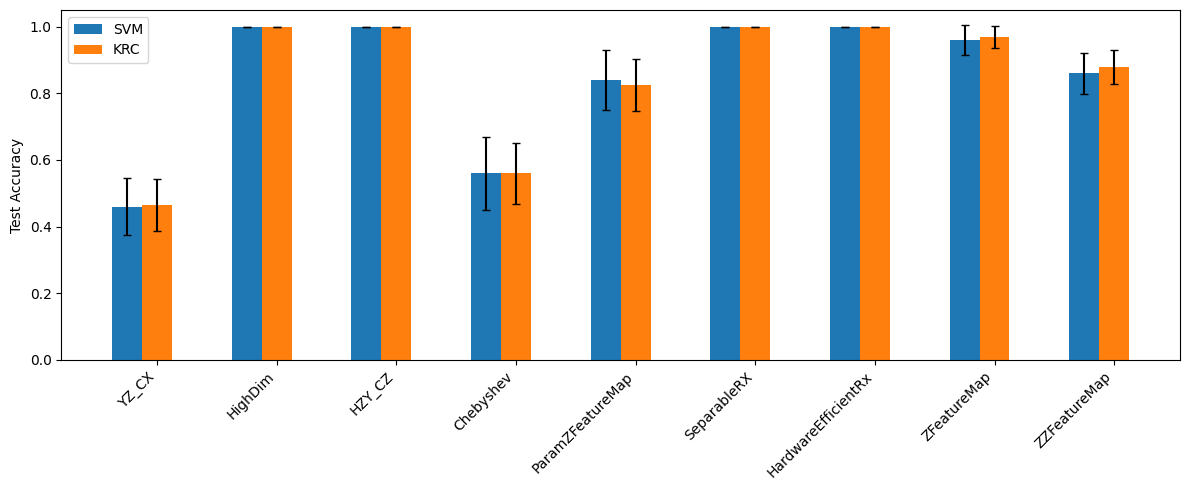

In [ ]:
def plot_accuracy(all_results):
    encodings = list(all_results.keys())
    models = ["SVM", "KRC"]
    
    test_accs = {m: [] for m in models}
    test_stds = {m: [] for m in models}
    
    for enc in encodings:
        for r in all_results[enc]:
            test_accs[r.model_name].append(r.test_accuracy)
            test_stds[r.model_name].append(r.test_std)
    
    x = np.arange(len(encodings))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    for i, model in enumerate(models):
        ax.bar(x + i*width, test_accs[model], width, 
               yerr=test_stds[model], label=model, capsize=3)
    
    ax.set_ylabel('Test Accuracy')
    ax.set_xticks(x + width)
    ax.set_xticklabels(encodings, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()

plot_accuracy(result_Iris["results"])

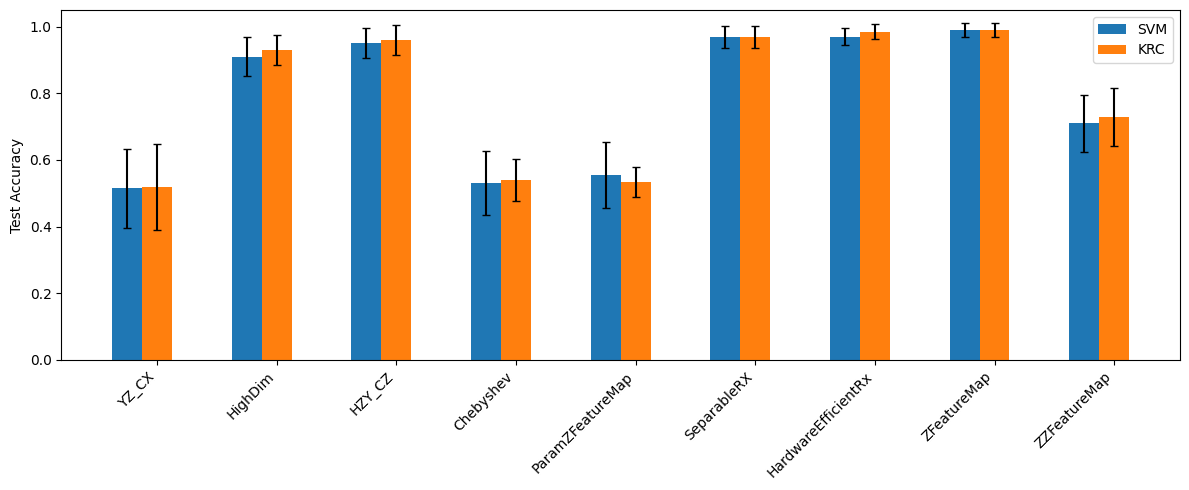

In [ ]:
plot_accuracy(result_Circle["results"])

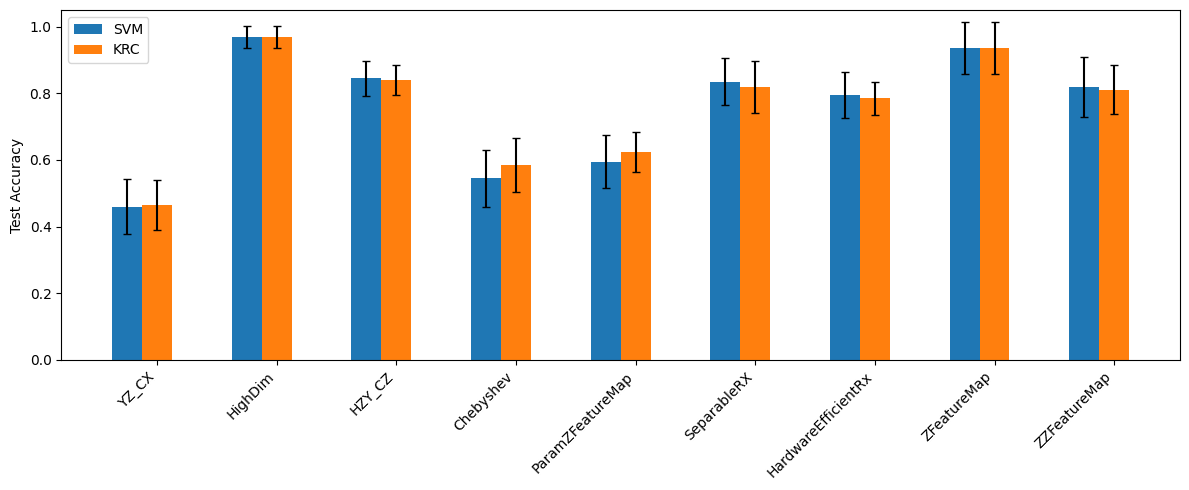

In [ ]:
plot_accuracy(result_Moons["results"])

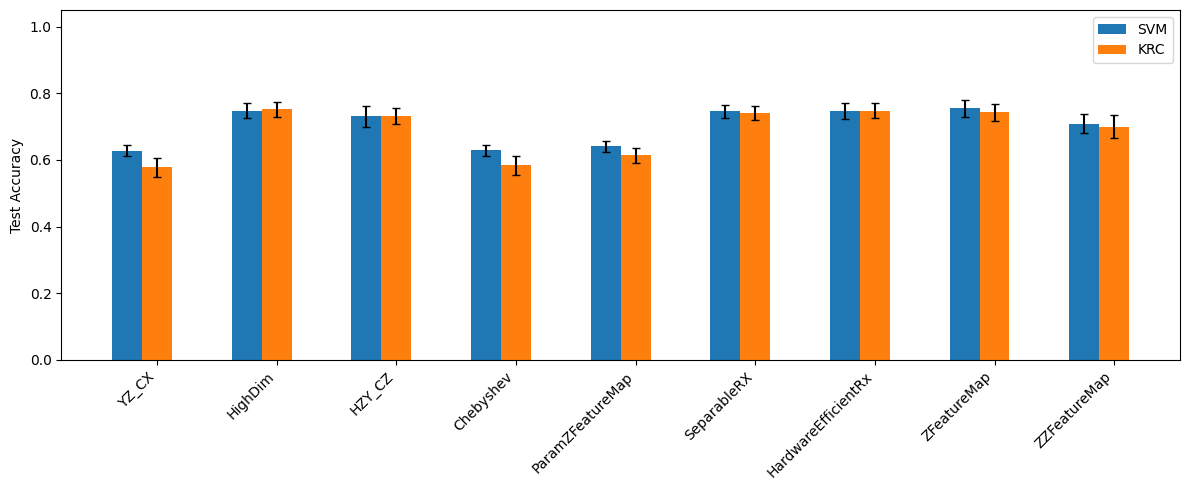

In [ ]:
plot_accuracy(result_Pima["results"])

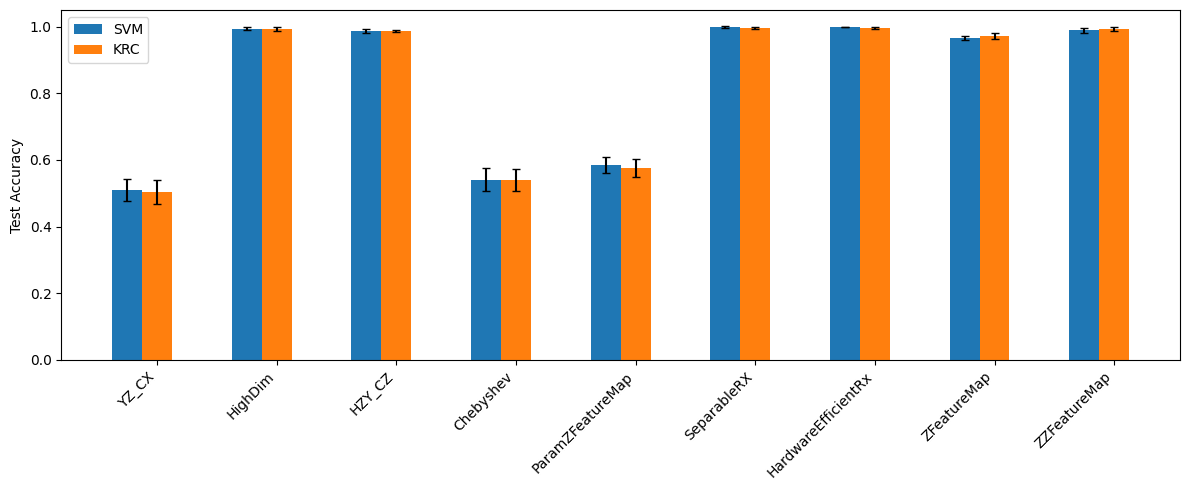

In [ ]:
plot_accuracy(result_Banknote["results"])

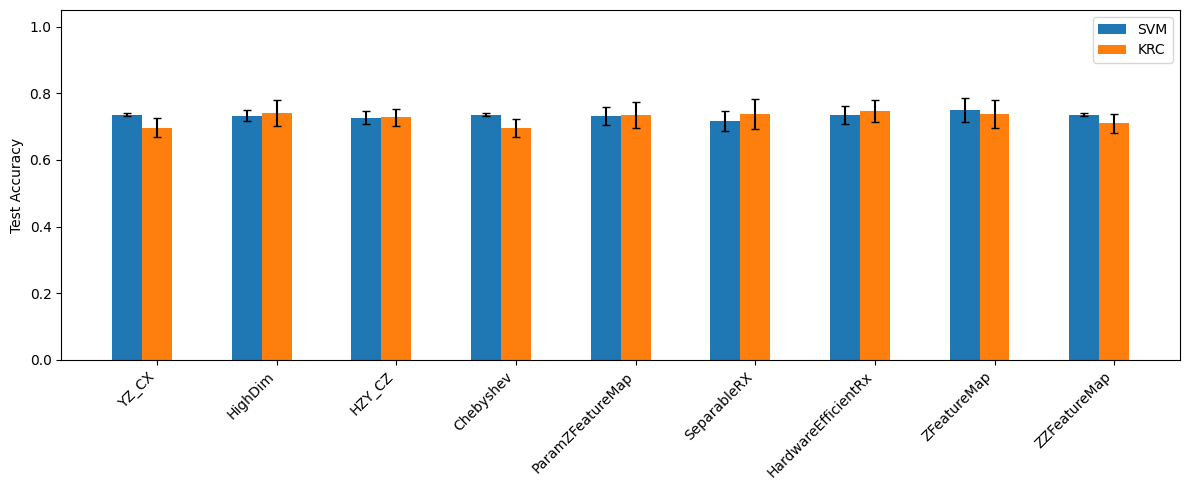

In [ ]:
plot_accuracy(result_Haberman["results"])

# Table summary for accuracy corresponds to 6 datasets

In [ ]:
import pandas as pd

def create_summary_table(all_dataset_results: Dict[str, Dict], 
                         model_name: str = "SVM") -> pd.DataFrame:
    encodings = list(ENCODING_REGISTER.keys())
    
    table_data = []
    for dataset_name, result_dict in all_dataset_results.items():
        row = {"Dataset": dataset_name}
        results = result_dict["results"]
        
        for enc_name in encodings:
            if enc_name in results:
                for r in results[enc_name]:
                    if r.model_name == model_name:
                        row[enc_name] = f"{r.test_accuracy:.4f}"
                        break
            else:
                row[enc_name] = "-"
        
        table_data.append(row)
    
    df = pd.DataFrame(table_data)
    df = df.set_index("Dataset")
    
    return df

In [ ]:
all_results = {}

for dataset_name in ["Circle", "Moons", "Iris", "Pima", "Banknote", "Haberman"]:
    print('-'*60)
    
    result = total_runs(
        dataset_name=dataset_name,
        n_layers=2,
        n_runs=10,
        random_state=42,
        verbose=True
    )
    all_results[dataset_name] = result

print("\n" + "-"*80)
print("SUMMARY TABLE (Test Accuracy - SVM)")
print("-"*80)
df_svm = create_summary_table(all_results, model_name="SVM")
print(df_svm.to_string())


------------------------------------------------------------
Dataset: Circle


100%|██████████| 10/10 [00:01<00:00,  9.42it/s]


------------------------------------------------------------
Dataset: Moons


100%|██████████| 10/10 [00:01<00:00,  9.64it/s]


------------------------------------------------------------
Dataset: Iris


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


------------------------------------------------------------
Dataset: Pima


100%|██████████| 10/10 [01:07<00:00,  6.70s/it]


------------------------------------------------------------
Dataset: Banknote


100%|██████████| 10/10 [02:29<00:00, 14.99s/it]


------------------------------------------------------------
Dataset: Haberman


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


--------------------------------------------------------------------------------
SUMMARY TABLE (Test Accuracy - SVM)
--------------------------------------------------------------------------------
           YZ_CX HighDim  HZY_CZ Chebyshev ParamZFeatureMap SeparableRX HardwareEfficientRx ZFeatureMap ZZFeatureMap
Dataset                                                                                                             
Circle    0.5200  0.9100  0.9550    0.5150           0.6150      0.9700              0.9700      0.9900       0.7100
Moons     0.4900  0.9700  0.8650    0.5400           0.5850      0.8350              0.7950      0.9350       0.8200
Iris      0.4650  1.0000  1.0000    0.5900           0.8750      1.0000              1.0000      0.9600       0.8600
Pima      0.6260  0.7481  0.7351    0.6279           0.6481      0.7455              0.7474      0.7545       0.7091
Banknote  0.5291  0.9938  0.9873    0.5364           0.5800      0.9985              1.0000      0.

In [ ]:
def label_dataframe(all_dataset_results: Dict[str, Dict], 
                          model_name: str = "SVM") -> pd.DataFrame:

    encodings = list(ENCODING_REGISTER.keys())
    
    table_data = []
    for dataset_name, result_dict in all_dataset_results.items():
        results = result_dict["results"]
        
        best_acc = 0
        best_kernel = None
        
        for enc_name in encodings:
            if enc_name in results:
                for r in results[enc_name]:
                    if r.model_name == model_name:
                        if r.test_accuracy > best_acc:
                            best_acc = r.test_accuracy
                            best_kernel = enc_name
                        break
        
        table_data.append({
            "Dataset": dataset_name,
            "Best_Kernel": best_kernel,
            "Accuracy": best_acc
        })
    
    df = pd.DataFrame(table_data)
    df = df.set_index("Dataset")
    
    return df

df_best = label_dataframe(all_results, model_name="SVM")
df_best

                  Best_Kernel  Accuracy
Dataset                                
Circle            ZFeatureMap  0.990000
Moons                 HighDim  0.970000
Iris                  HighDim  1.000000
Pima              ZFeatureMap  0.754545
Banknote  HardwareEfficientRx  1.000000
Haberman          ZFeatureMap  0.750820


# Data Complexity Procedure

### Classical Metrics

Datasets ở đây sẽ là bài toán Classification
- Do đó, thư viện problexity sẽ có 22 metrics + 2 metrics từ Qdata --> 24 metrics
- 6 datasets, được MinMaxScaler về range (0, 1)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
datasets = load_datasets(data_dir="datasets",feature_range=(0, 1), test_size=0.2)
complexities_datasets = {}  

for name, (X_tr, X_te, y_tr, y_te) in datasets.items():  
    complexities_train = [] 
    for i in range(10):
        cc = px.ComplexityCalculator()
        cc.fit(X_tr, y_tr)
        results = list(cc.complexity)
        results.append(kolmogorov_complex(X_tr)['best_bytes'])
        results.append(intrinsic_dim_from_cov(X_tr))
        complexities_train.append(results)

    complexities_train = np.array(complexities_train)
    complexities_datasets[name] = np.mean(complexities_train, axis=0)

In [ ]:
labels = cc._metrics() + ['kolmogorov', 'intrinsic']
print(f"Number of metrics: {len(labels)}")
print(f"Labels: {labels}")

df = pd.DataFrame.from_dict(complexities_datasets, orient='index', columns=labels)
df

Number of metrics: 24
Labels: ['f1', 'f1v', 'f2', 'f3', 'f4', 'l1', 'l2', 'l3', 'n1', 'n2', 'n3', 'n4', 't1', 'lsc', 'density', 'clsCoef', 'hubs', 't2', 't3', 't4', 'c1', 'c2', 'kolmogorov', 'intrinsic']


,f1,f1v,f2,f3,f4,l1,l2,l3,n1,n2,...,density,clsCoef,hubs,t2,t3,t4,c1,c2,kolmogorov,intrinsic
Circle,0.999427,0.998763,0.370629,0.687500,0.512500,0.097503,0.500000,0.481250,0.037500,0.212004,...,0.924684,0.345261,0.808988,0.025000,0.025000,1.000,0.000000,0.000000,0.978395,1.990357
Moons,0.282043,0.113886,0.150613,0.412500,0.175000,0.014392,0.112500,0.083750,0.006250,0.148102,...,0.887658,0.275100,0.802933,0.025000,0.025000,1.000,0.000000,0.000000,0.974537,1.691315
Iris,0.027375,0.009183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006250,0.099604,...,0.740190,0.203694,0.622049,0.050000,0.025000,0.500,0.000000,0.000000,0.256211,1.311611
Pima,0.627298,0.324994,0.252242,0.993475,0.975530,0.020677,0.205546,0.187602,0.140294,0.416088,...,0.927022,0.494670,0.787246,0.013051,0.011419,0.875,0.068210,0.170274,0.244490,5.452643
Banknote,0.317944,0.037186,0.160221,0.661805,0.347311,0.000351,0.016408,0.005652,0.001367,0.103779,...,0.893770,0.286159,0.779433,0.003646,0.002735,0.750,0.008794,0.024040,0.863846,2.405848
Haberman,0.816103,0.614929,0.701016,0.975410,0.971311,0.054637,0.258197,0.254098,0.159836,0.341303,...,0.881805,0.410170,0.680321,0.012295,0.012295,1.000,0.163758,0.358352,0.194109,2.249480


In [ ]:
df["Best_Kernel"] = df_best["Best_Kernel"]
df

,f1,f1v,f2,f3,f4,l1,l2,l3,n1,n2,...,clsCoef,hubs,t2,t3,t4,c1,c2,kolmogorov,intrinsic,Best_Kernel
Circle,0.999427,0.998763,0.370629,0.687500,0.512500,0.097503,0.500000,0.481250,0.037500,0.212004,...,0.345261,0.808988,0.025000,0.025000,1.000,0.000000,0.000000,0.978395,1.990357,ZFeatureMap
Moons,0.282043,0.113886,0.150613,0.412500,0.175000,0.014392,0.112500,0.083750,0.006250,0.148102,...,0.275100,0.802933,0.025000,0.025000,1.000,0.000000,0.000000,0.974537,1.691315,HighDim
Iris,0.027375,0.009183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006250,0.099604,...,0.203694,0.622049,0.050000,0.025000,0.500,0.000000,0.000000,0.256211,1.311611,HighDim
Pima,0.627298,0.324994,0.252242,0.993475,0.975530,0.020677,0.205546,0.187602,0.140294,0.416088,...,0.494670,0.787246,0.013051,0.011419,0.875,0.068210,0.170274,0.244490,5.452643,ZFeatureMap
Banknote,0.317944,0.037186,0.160221,0.661805,0.347311,0.000351,0.016408,0.005652,0.001367,0.103779,...,0.286159,0.779433,0.003646,0.002735,0.750,0.008794,0.024040,0.863846,2.405848,HardwareEfficientRx
Haberman,0.816103,0.614929,0.701016,0.975410,0.971311,0.054637,0.258197,0.254098,0.159836,0.341303,...,0.410170,0.680321,0.012295,0.012295,1.000,0.163758,0.358352,0.194109,2.249480,ZFeatureMap
